# Hodrick-Prescott filter

Separates a time series $y_t$ into a trend $\tau_t$ and a cyclical component $c_t$.

$y_t = \tau_t + c_t$

It does the decomposition by minimising a quadratic loss function:

$min_{\tau_t} \sum_{t=1}^T c_t^2 + \lambda \sum_{t=1}^T [(\tau_t - \tau_{t-1}) - (\tau_{t-1} - {\tau_{t-2}})]^2  $

where $\lambda$ is a smoothing parameter, meaning it handles variations in the growth rate of the trend component.

Recommended $\lambda$ value depends on the time unit analysed. Recommended values are:
* 1600 for quarterly 
* 6.25 for annual 
* 129600 for monthly 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter

In [4]:
#TODO explain where data is from 

df = pd.read_csv("Data/macrodata.csv", index_col=0, parse_dates=True)

In [5]:
gdp_cyclic, gdp_trend = hpfilter(df["realgdp"], lamb=1600)

Text(0.5, 0, 'Year')

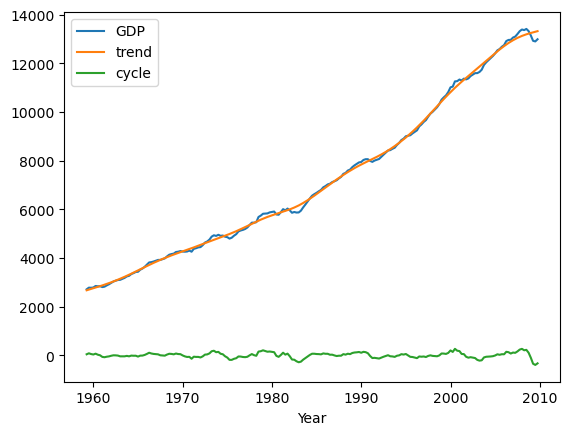

In [6]:
plt.plot(df["realgdp"], label="GDP")
plt.plot(gdp_trend, label="trend")
plt.plot(gdp_cyclic, label="cycle")
plt.legend()
plt.xlabel("Year")

# Error-Trend-Seasonality (ETS) models

Include:
* Exponential Smoothing
* Trend Methods Model
* ETS Decomposition

Model types:
* Additive: use when the trend is linear and the seasonality is constant over time. E.g. x increases by y in every unit of time. 
* Multiplicative: use when trend is not linear. E.g. rate of x increases y-fold in every unit of time. 

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
airline_data = pd.read_csv("Data/airline_passengers.csv", index_col="Month", parse_dates=True)
airline_data = airline_data.dropna()

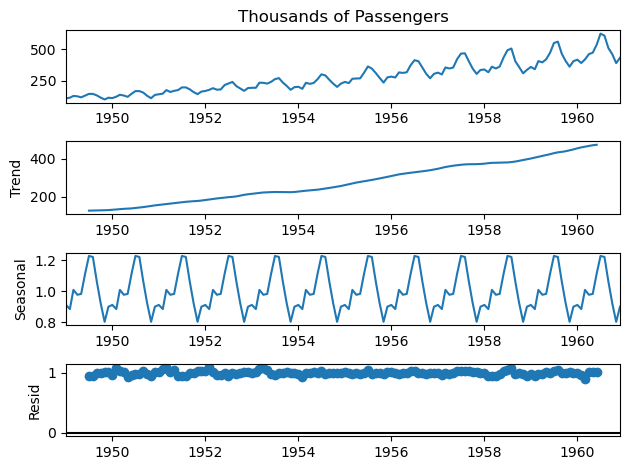

In [9]:
airline_data_decomposed = seasonal_decompose(airline_data["Thousands of Passengers"], model="multiplicative")
airline_data_decomposed.plot();                                                       

# Exponentially Weighted Moving Average (EWMA)

In Simple Moving Average (SMA), the same window size is for all of the data. Data in the whole window sizeis treated with equal importance.

Weaknesses of SMA:
* Small window size increases singal/noise ratio.
* Lags by the size of one window.
* Can approach but never reaches  minimum and maximum values of the data. Due to averaging, it has a smaller value range than the data itself.
* Describes trends presen in the data, but cannot create predictions.
* Can be skewed by extreme events (outliers) present in the past.

In [10]:
airline_data["6-month-SMA"] = airline_data["Thousands of Passengers"].rolling(window=6).mean()
airline_data["12-month-SMA"] = airline_data["Thousands of Passengers"].rolling(window=12).mean()

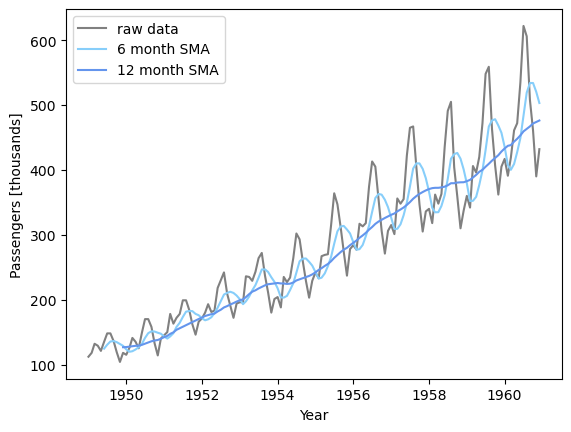

In [11]:
plt.plot(airline_data["Thousands of Passengers"], label="raw data", color="grey")
plt.plot(airline_data["6-month-SMA"], label="6 month SMA", color="lightskyblue")
plt.plot(airline_data["12-month-SMA"], label="12 month SMA", color="cornflowerblue")
plt.ylabel("Passengers [thousands]")
plt.xlabel("Year")
plt.legend()
plt.show()

Improvements achieved wih EWMA:
* Reduced lag effect.
* Applies more weight to more recent data.

EWMA parameters:
* Amount of weight applied to more recent data.
* Number of periods in the window.

EWMA is calculated as follows:

$y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

$x_t$ is the input value

$w_i$ is the weighting, which changes and takes values from i to t

$y_t$ is the output

We use pandas built-in ewm function.


In [12]:
airline_data["6-month-EWMA"] = airline_data["Thousands of Passengers"].ewm(span=6).mean()
airline_data["12-month-EWMA"] = airline_data["Thousands of Passengers"].ewm(span=12).mean()


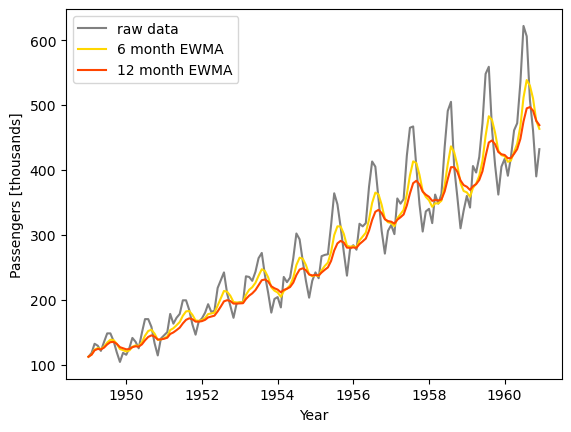

In [13]:
plt.plot(airline_data["Thousands of Passengers"], label="raw data", color="grey")
plt.plot(airline_data["6-month-EWMA"], label="6 month EWMA", color="gold")
plt.plot(airline_data["12-month-EWMA"], label="12 month EWMA", color="orangered")
plt.ylabel("Passengers [thousands]")
plt.xlabel("Year")
plt.legend()
plt.show()

By default, the parameter for adjusting weight $w_i$n is set to True. This results in the following weight update:
### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

This nominator means that history of x values is being included in the calculation of $y_t$. At the same time, x values from some number of steps ago have their value decreased as a function of that number of steps: $(1 - \alpha)^{nr\_steps} x_{t-{nr\_steps}}$.

The denominator. It is the sum of the weights and allows to calculate the weighted average. What do we mean by "the weighted sum"? Lets simplify.

To calculate the average of a and b:

$average\_{ab} = \frac{a + b}{2}$

However, if we wanted the weight of a to be 3 times larger than b, the equation would be:

$weighted\_average\_{ab} = \frac{3a + b}{3 + 1}$

This equation can be expressed as 

When it is set to False, the update becomes:

#### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t\end{split}$

Which means that initially y is equal x. During all subsequent steps, y is composed of two parts:
* $(1 - \alpha) y_{t-1}$, which is equal to the value of y from the previous time step minus the proportion $\alpha$
* $\alpha x_t$, which is the current value of x decreased by the proportion $\alpha$


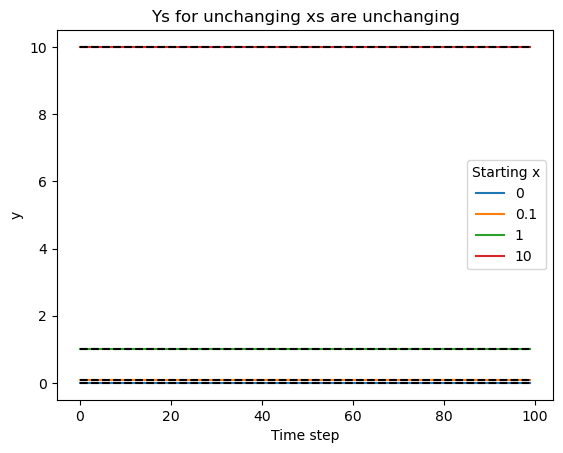

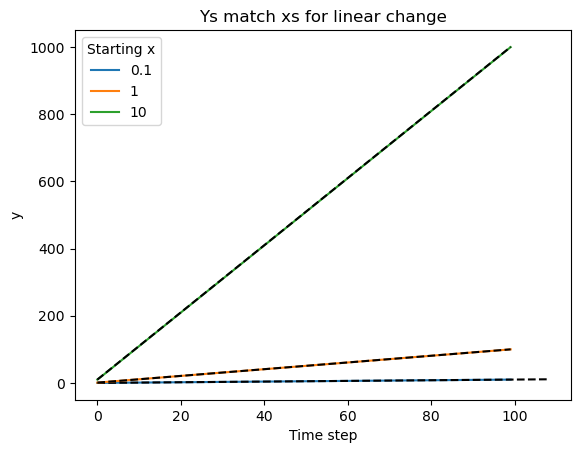

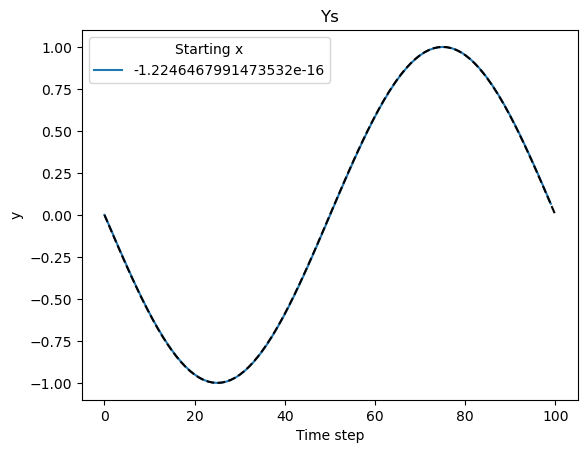

In [36]:
# Exploration of $w_i$ without adjustment

def ewma_weight_without_adjustment(x, alpha=0.95, time_steps=100):
    """
    Assumes x is static.
    """
    y = [None] * time_steps
    y[0] = x[0]
    for t in range(1, time_steps):
        y[t] = (1-alpha)*y[t-1] + alpha*x[t]
    return y

def plot_ys_for_xs(xs, time_steps, plot_title=""):
    for x in xs:
        plt.plot(ewma_weight_without_adjustment(x=x, time_steps=time_steps), label=str(x[0]))
        plt.plot(x, "k--")
    plt.legend(title="Starting x")
    plt.xlabel("Time step")
    plt.ylabel("y")
    plt.title(plot_title)
    plt.show()
    
time_steps = 100
xs = [[0]*time_steps, [0.1]*time_steps, [1]*time_steps, [10]*time_steps]
plot_title = "Ys for unchanging xs are unchanging"
plot_ys_for_xs(xs, time_steps, plot_title=plot_title)

time_steps = 100
xs = [np.arange(start=0.1, stop=0.1*time_steps+1, step=0.1), np.arange(start=1,stop=1*time_steps+1, step=1), np.arange(start=10, stop=10*time_steps+1, step=10)]
plot_title = "Ys match xs for linear change"
plot_ys_for_xs(xs, time_steps, plot_title=plot_title)


sin_bootstrap = np.linspace(-np.pi, np.pi, time_steps + 1)
xs = [[np.sin(i) for i in sin_bootstrap]]
plot_title = "Ys"
plot_ys_for_xs(xs, time_steps, plot_title=plot_title)